In [3]:
import torch
from torch import nn
import numpy as np
from torch.distributions import Normal, Laplace
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
import seaborn as sns

In [13]:
from bernstein_transformation_layer import *
#from training_helpers import *

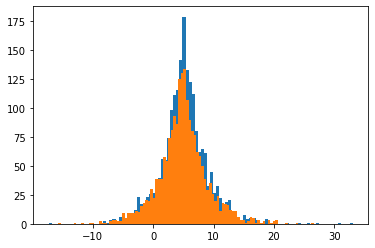

In [41]:
y_distribution = Laplace(5, 3)
y = y_distribution.sample((2000,2)) # Generate training data
plt.hist(y[:,0].numpy(), bins=100)
plt.hist(y[:,1].numpy(), bins=100)
plt.show()

In [42]:
polynomial_range = torch.FloatTensor([[-30, -30],
                                          [40, 40]])
mctm = Transformation(degree=12, number_variables=2, polynomial_range=polynomial_range)

100%|██████████| 3000/3000 [00:50<00:00, 59.10it/s]


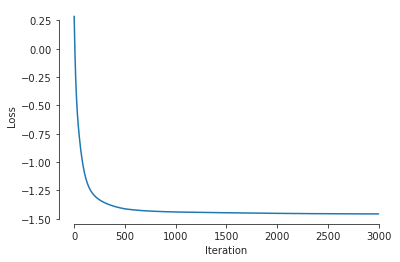

In [45]:
train(mctm, y, iterations=3000, verbose=False)

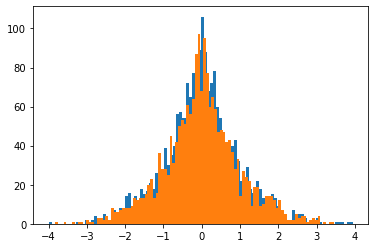

In [46]:
z, log_d = mctm.forward(y)
plt.hist(z[:,0].detach().numpy(), bins=100)
plt.hist(z[:,1].detach().numpy(), bins=100)
plt.show()

100%|██████████| 5000/5000 [02:35<00:00, 32.21it/s]


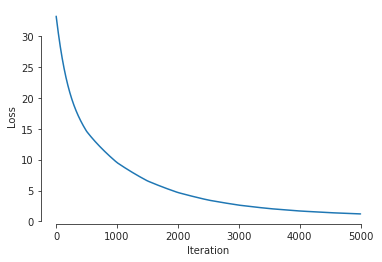

In [47]:
polynomial_range = torch.FloatTensor([[-10, -10],
                                          [10, 10]])
mctm.approximate_inverse(y, polynomial_range_inverse= polynomial_range, iterations=5000)
# use cubic splines for approx?
# use linespace to have more observations to train on?
# how is it done in the tensorflow implementation

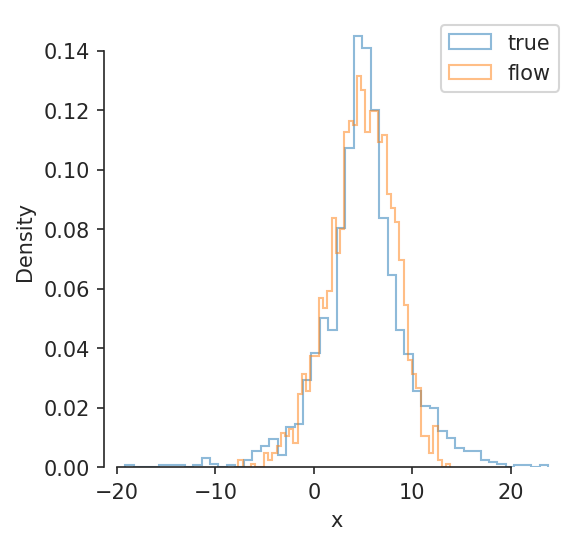

In [48]:
evaluate(mctm)

In [245]:
def multivariable_lambda_prediction(input, degree, number_variables, params, polynomial_range, inverse=False):

    #steps
    output = input.clone()
    # loop over all variables
    params_index = 0

    for var_num in range(number_variables):
        #print(var_num)
        # loop over all before variables
        for covar_num in range(var_num):
            #print(covar_num)
            #print(params_index)

            # compute lambda fct value using before variable
            if inverse:
                lambda_value = bernstein_prediction(params[:, params_index], output[:,covar_num], degree, polynomial_range[:,covar_num], monotonically_increasing=False, derivativ=0)
            else:
                lambda_value = bernstein_prediction(params[:, params_index], input[:,covar_num], degree, polynomial_range[:,covar_num], monotonically_increasing=False, derivativ=0)

            # update
            # Cloning issue?
            if inverse:
                output[:,var_num] = output[:,var_num] - lambda_value * output[:,covar_num]
            else:
                output[:,var_num] = output[:,var_num] + lambda_value * input[:,covar_num]

            params_index += 1

    return output

class Decorrelation(nn.Module):
    def __init__(self, degree, number_variables, polynomial_range):
        super().__init__()
        self.degree  = degree
        self.number_variables = number_variables
        self.polynomial_range = polynomial_range
        self.num_lambdas = number_variables * (number_variables-1) / 2
        # https://discuss.pytorch.org/t/how-to-turn-list-of-varying-length-tensor-into-a-tensor/1361
        # param dims: 0: basis, 1: variable
        p = torch.FloatTensor(np.repeat(np.repeat(0.1,self.degree+1), self.num_lambdas))

        if self.num_lambdas == 1:
            self.params = nn.Parameter(p.unsqueeze(1))
        else:
            self.params = nn.Parameter(torch.reshape(p,(self.degree+1, int(self.num_lambdas))))

    def forward(self, input, log_d = 0, inverse = False):
        if not inverse:
            output = multivariable_lambda_prediction(input, self.degree, self.number_variables, self.params, self.polynomial_range)
        else:
            output = multivariable_lambda_prediction(input, self.degree, self.number_variables, self.params, self.polynomial_range, inverse=True)
        return output, log_d

    #def __repr__(self):
    #    return "Affine(alpha={alpha:.2f}, beta={beta:.2f})".format(alpha = self.alpha[0], beta = self.beta[0])

In [220]:
polynomial_range = torch.FloatTensor([[-30, -30, -30],
                                          [40, 40, 40]])
decorr = Decorrelation(degree=12, number_variables=3, polynomial_range=polynomial_range)

In [51]:
decorr.params

Parameter containing:
tensor([[0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000]], requires_grad=True)

In [222]:
from torch.distributions.multivariate_normal import MultivariateNormal
loc = torch.zeros(3)
lam = torch.Tensor([[1, 0, 0],
                    [3, 1, 0],
                    [0, 0, 1]])
scale = lam @ torch.eye(3) @ torch.transpose(lam,0,1)
y_distribution = MultivariateNormal(loc, scale)
y = y_distribution.sample((2000,1)) # Generate training data
y = y.reshape((2000,3))
y.size()

torch.Size([2000, 3])

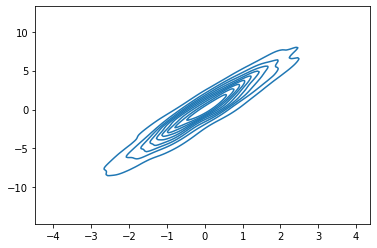

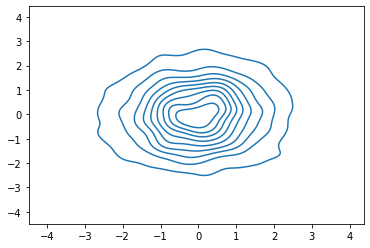

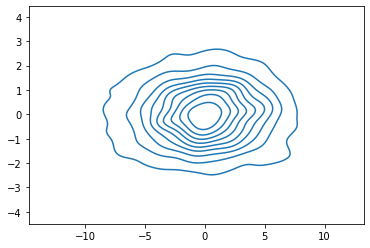

In [223]:
sns.kdeplot(x=y[:,0], y=y[:,1])
plt.show()
sns.kdeplot(x=y[:,0], y=y[:,2])
plt.show()
sns.kdeplot(x=y[:,1], y=y[:,2])
plt.show()

In [224]:
polynomial_range = torch.FloatTensor([[-15, -15, -15],
                                          [15, 15, 15]])
decorr = Decorrelation(degree=12, number_variables=3, polynomial_range=polynomial_range)

In [225]:
decorr.params

Parameter containing:
tensor([[0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000]], requires_grad=True)

100%|██████████| 2000/2000 [00:17<00:00, 116.60it/s]


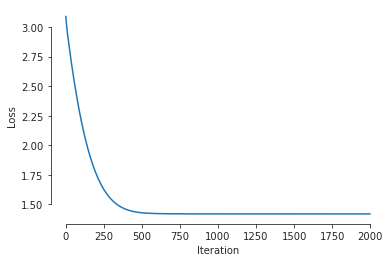

In [226]:
train(decorr, y, iterations=2000, verbose=False)

In [227]:
decorr.params

Parameter containing:
tensor([[-3.2286,  0.9374, -1.2644],
        [-3.1724,  0.8942,  0.6193],
        [-3.1252,  0.7831,  0.1601],
        [-3.0867,  0.5953, -0.4799],
        [-3.0559,  0.3341, -0.1253],
        [-3.0307,  0.0304,  0.4678],
        [-3.0077, -0.2524,  0.1412],
        [-2.9833, -0.4304, -0.4672],
        [-2.9540, -0.4241, -0.1867],
        [-2.9173, -0.1798,  0.5133],
        [-2.8726,  0.3229,  0.5430],
        [-2.8202,  1.0715, -0.4114],
        [-2.7610,  2.0180, -1.2952]], requires_grad=True)

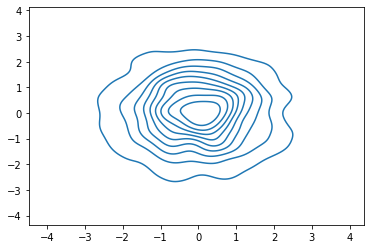

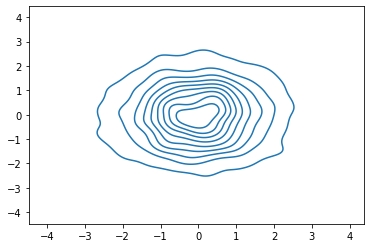

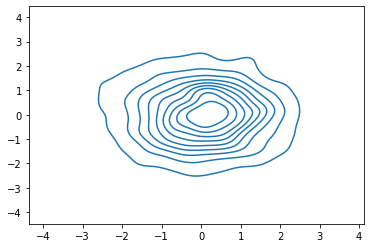

In [228]:
z, log_d = decorr.forward(y)
z = z.detach().numpy()
sns.kdeplot(x=z[:,0], y=z[:,1])
plt.show()
sns.kdeplot(x=z[:,0], y=z[:,2])
plt.show()
sns.kdeplot(x=z[:,1], y=z[:,2])
plt.show()

In [231]:
from torch.distributions.multivariate_normal import MultivariateNormal
loc = torch.zeros(2)
lam = torch.Tensor([[1, 0],
                    [1.5, 1]])
scale = lam @ torch.eye(2) @ torch.transpose(lam,0,1)
y_distribution = MultivariateNormal(loc, scale)
y = y_distribution.sample((2000,1)) # Generate training data
y = y.reshape((2000,2))
y.size()

torch.Size([2000, 2])

In [232]:
polynomial_range = torch.FloatTensor([[-10],[10]])
decorr = Decorrelation(degree=12, number_variables=2, polynomial_range=polynomial_range)

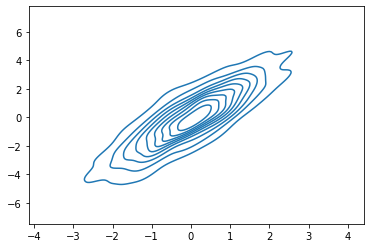

In [233]:
sns.kdeplot(x=y[:,0], y=y[:,1])
plt.show()

100%|██████████| 2000/2000 [00:06<00:00, 289.13it/s]


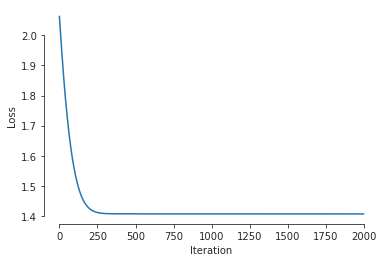

In [234]:
train(decorr, y, iterations=2000, verbose=False)

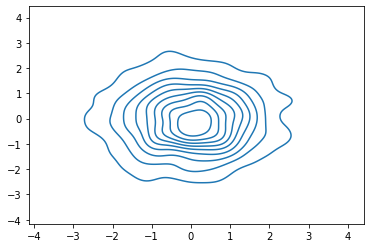

In [235]:
z, log_d = decorr.forward(y)
z = z.detach().numpy()
sns.kdeplot(x=z[:,0], y=z[:,1])
plt.show()

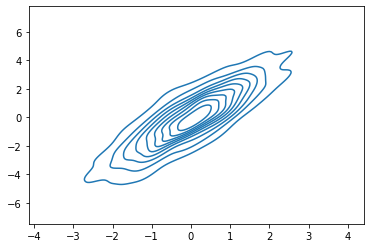

In [246]:
z, log_d = decorr.forward(y)
y_hat, log_d = decorr.forward(z, inverse=True)

y_hat = y_hat.detach().numpy()
sns.kdeplot(x=y_hat[:,0], y=y_hat[:,1])
plt.show()

In [247]:
# Inverse works!
y_hat, log_d = decorr.forward(z, inverse=True)
y == y_hat

tensor([[True, True],
        [True, True],
        [True, True],
        ...,
        [True, True],
        [True, True],
        [True, True]])